Saving P12.png to P12 (1).png
[OK] 30 points → lines_44b.hex / points_1920x1080.csv 생성 (sx=1.661, sy=0.980, PACK_MODE=44, Xband=[450,1470])
첫 8줄 미리보기:
6AE05989847
62611D6C84E
5B21394B89C
52E270E112A
3844A90595A
41656945951
51654589A14
626851203F4


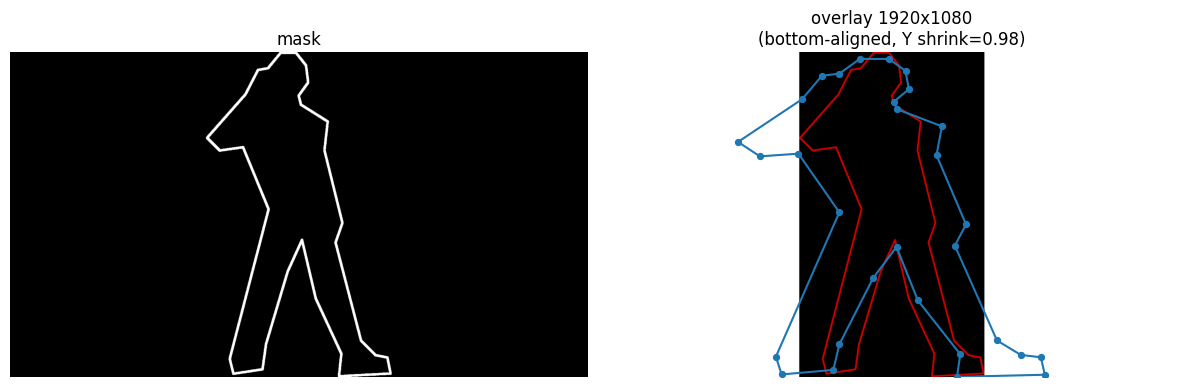

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import numpy as np, cv2, os
import matplotlib.pyplot as plt
from google.colab import files

# =========================
# 해상도/밴드/패킹 설정
# =========================
TARGET_W, TARGET_H = 1920, 1080             # [변경] 타깃 해상도
_MARGIN_RATIO = 150/640                      # 640에서 좌우 150px → 비율 0.234375
X_BAND_MIN = int(round(TARGET_W * _MARGIN_RATIO))     # [자동계산] 1920*0.234375 ≈ 450
X_BAND_MAX = TARGET_W - X_BAND_MIN                     # 1470
Y_SHRINK   = 0.98

# 패킹 모드: '38' = (x10,y9,x10,y9), '44' = (x11,y11,x11,y11)
PACK_MODE = '44'    # [추가] 1080p를 온전히 담으려면 '44' 권장. (RTL도 같이 변경 필요)

# =========================
# 패킹 함수
# =========================
def pack_xy(x1, y1, x2, y2, mode='38'):
    if mode == '38':
        # x:10비트(0..1023), y:9비트(0..511) → 38비트
        if not (0 <= x1 <= 1023 and 0 <= x2 <= 1023 and 0 <= y1 <= 511 and 0 <= y2 <= 511):
            raise ValueError(f"[38b] out of range: ({x1},{y1})->({x2},{y2})")
        w  = (x1 & 0x3FF) << 28
        w |= (y1 & 0x1FF) << 19
        w |= (x2 & 0x3FF) <<  9
        w |= (y2 & 0x1FF)
        return f"{w:010X}"  # 38b → 10 hex
    elif mode == '44':
        # x:11비트(0..2047), y:11비트(0..2047) → 44비트
        if not (0 <= x1 <= 2047 and 0 <= x2 <= 2047 and 0 <= y1 <= 2047 and 0 <= y2 <= 2047):
            raise ValueError(f"[44b] out of range: ({x1},{y1})->({x2},{y2})")
        w  = (x1 & 0x7FF) << 33
        w |= (y1 & 0x7FF) << 22
        w |= (x2 & 0x7FF) << 11
        w |= (y2 & 0x7FF)
        return f"{w:011X}"  # 44b → 11 hex
    else:
        raise ValueError("PACK_MODE must be '38' or '44'")

# =========================
# 유틸
# =========================
def ensure_clockwise(pts):
    pts = np.asarray(pts)
    x, y = pts[:,0], pts[:,1]
    area2 = np.sum(x*np.roll(y,-1) - np.roll(x,-1)*y)
    if area2 > 0:  # CCW → CW
        pts = pts[::-1].copy()
    return pts

def to_letterbox(img_bgr, W, H):
    h, w = img_bgr.shape[:2]
    scale = min(W/w, H/h)
    newW, newH = int(w*scale), int(h*scale)
    resized = cv2.resize(img_bgr, (newW, newH), interpolation=cv2.INTER_AREA)
    canvas = np.full((H, W, 3), 255, dtype=np.uint8)
    ox, oy = (W-newW)//2, H-newH
    canvas[oy:oy+newH, ox:ox+newW] = resized
    return canvas, ox, oy, scale

def extract_red_contour(vga_bgr,
                        erode_iter=0, dilate_iter=1,
                        hmin=0, hmax=10, hmin2=170, hmax2=180,
                        smin=80, vmin=80):
    hsv = cv2.cvtColor(vga_bgr, cv2.COLOR_BGR2HSV)
    m1 = cv2.inRange(hsv, (hmin,  smin, vmin), (hmax, 255, 255))
    m2 = cv2.inRange(hsv, (hmin2, smin, vmin), (hmax2,255, 255))
    mask = cv2.bitwise_or(m1, m2)
    if erode_iter:  mask = cv2.erode(mask, None, iterations=erode_iter)
    if dilate_iter: mask = cv2.dilate(mask, None, iterations=dilate_iter)
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        raise RuntimeError("빨간 외곽선을 찾지 못했습니다. HSV/erode/dilate 파라미터를 조정하세요.")
    cnt = max(cnts, key=cv2.contourArea)
    return cnt, mask

def approx_to_N_points(contour, target_N=30):
    peri = cv2.arcLength(contour, True)
    lo, hi = 0.0, 0.15*peri
    best = None
    for _ in range(30):
        eps = (lo+hi)/2
        approx = cv2.approxPolyDP(contour, eps, True)
        n = len(approx)
        if n == target_N:
            best = approx; break
        if n > target_N: lo = eps
        else: hi = eps
        if best is None or abs(n-target_N) < abs(len(best)-target_N):
            best = approx
    pts = (best if best is not None else approx).reshape(-1,2)

    if len(pts) != target_N:
        C = contour.reshape(-1,2)
        seg = np.sqrt(np.sum(np.diff(C, axis=0, append=C[:1])**2, axis=1))
        s = np.cumsum(seg); s = np.insert(s, 0, 0)
        L = s[-1]
        t = np.linspace(0, L, target_N, endpoint=False)
        out = []
        for ti in t:
            idx = np.searchsorted(s, ti, side="right")-1
            p0 = C[idx]; p1 = C[(idx+1)%len(C)]
            l0, l1 = s[idx], s[idx+1]
            a = 0 if l1==l0 else (ti-l0)/(l1-l0)
            out.append((1-a)*p0 + a*p1)
        pts = np.array(out, dtype=np.float32)
    return pts.astype(np.int32)

# =========================
# 변환 (X 밴드 맞추고, Y 살짝 축소 + 하단 정렬)
# =========================
def transform_fit_xband_bottom_shrinkY(pts,
                                       target_w=TARGET_W, target_h=TARGET_H,
                                       x_min=X_BAND_MIN, x_max=X_BAND_MAX,
                                       y_shrink=Y_SHRINK):
    P = np.asarray(pts, dtype=np.float32)

    x0, y0 = P[:,0].min(), P[:,1].min()
    x1, y1 = P[:,0].max(), P[:,1].max()
    w0 = max(1.0, x1 - x0)
    h0 = max(1.0, y1 - y0)
    cx0 = (x0 + x1) * 0.5
    cy0 = (y0 + y1) * 0.5

    avail_w = x_max - x_min
    sx = avail_w / w0
    sy = float(y_shrink)

    h1 = h0 * sy
    cx_t = (x_min + x_max) * 0.5
    cy_t = (target_h - 1) - (h1 * 0.5)

    P2 = P.copy()
    P2[:,0] = (P2[:,0] - cx0) * sx + cx_t
    P2[:,1] = (P2[:,1] - cy0) * sy + cy_t

    P2 = np.rint(P2).astype(np.int32)
    P2[:,0] = np.clip(P2[:,0], 0, target_w - 1)
    P2[:,1] = np.clip(P2[:,1], 0, target_h - 1)
    return P2, (sx, sy), h1

def transform_and_pack_hex_lines_bottom_shrinkY(pts):
    pts = ensure_clockwise(pts)
    pts2, (sx, sy), h1 = transform_fit_xband_bottom_shrinkY(pts)
    hex_lines = []
    n = len(pts2)
    for i in range(n):
        x1, y1 = map(int, pts2[i])
        x2, y2 = map(int, pts2[(i+1) % n])
        # 화면 범위 클램프
        x1 = max(0, min(TARGET_W-1, x1)); x2 = max(0, min(TARGET_W-1, x2))
        y1 = max(0, min(TARGET_H-1, y1)); y2 = max(0, min(TARGET_H-1, y2))

        # [주의] 패킹 모드에 따라 비트폭/포맷 다름
        if PACK_MODE == '38':
            # 38비트 포맷 한계에 맞추어 다운스케일/클램프
            xs1 = int(round(x1 * 1023 / (TARGET_W-1)))
            xs2 = int(round(x2 * 1023 / (TARGET_W-1)))
            ys1 = int(round(y1 *  511 / (TARGET_H-1)))
            ys2 = int(round(y2 *  511 / (TARGET_H-1)))
            hex_lines.append(pack_xy(xs1, ys1, xs2, ys2, '38'))
        else:
            # 44비트 포맷 (x,y 11비트)
            hex_lines.append(pack_xy(x1, y1, x2, y2, '44'))
    return hex_lines, (sx, sy), pts2

# =========================
# 실행
# =========================
up = files.upload()
img_path = list(up.keys())[0]

src = cv2.imread(img_path, cv2.IMREAD_COLOR)
canvas, offx, offy, scl = to_letterbox(src, TARGET_W, TARGET_H)

TARGET_N = 30
ERODE, DILATE = 0, 1
HMIN, HMAX   = 0, 10
HMIN2,HMAX2  = 170, 180
SMIN, VMIN   = 80, 80
cnt, mask = extract_red_contour(canvas, ERODE, DILATE, HMIN, HMAX, HMIN2, HMAX2, SMIN, VMIN)
pts = approx_to_N_points(cnt, TARGET_N)

hex_lines, (sx, sy), pts2 = transform_and_pack_hex_lines_bottom_shrinkY(pts)

# 저장
hex_name = "lines_{}b.hex".format(38 if PACK_MODE=='38' else 44)
open(hex_name,"w").write("\n".join(hex_lines))
open("points_{}x{}.csv".format(TARGET_W, TARGET_H),"w").write("\n".join([f"{x},{y}" for x,y in pts2]))

print(f"[OK] {len(pts2)} points → {hex_name} / points_{TARGET_W}x{TARGET_H}.csv 생성 "
      f"(sx={sx:.3f}, sy={sy:.3f}, PACK_MODE={PACK_MODE}, Xband=[{X_BAND_MIN},{X_BAND_MAX}])")
print("첫 8줄 미리보기:")
print("\n".join(hex_lines[:8]))

# 미리보기
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.title("mask"); plt.axis("off"); plt.imshow(mask, cmap="gray")
plt.subplot(1,2,2); plt.title(f"overlay {TARGET_W}x{TARGET_H}\n(bottom-aligned, Y shrink={Y_SHRINK})"); plt.axis("off")
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
pp = np.vstack([pts2, pts2[0]])
plt.plot(pp[:,0], pp[:,1])
plt.scatter(pts2[:,0], pts2[:,1], s=18)
plt.tight_layout(); plt.show()

# 다운로드
def _in_colab():
    try:
        import google.colab  # noqa
        return True
    except ImportError:
        return False

if _in_colab():
    from google.colab import files
    files.download(hex_name)
    files.download("points_{}x{}.csv".format(TARGET_W, TARGET_H))
else:
    try:
        from IPython.display import FileLink, display
        display(FileLink(hex_name, result_html_prefix="Download HEX: "))
        display(FileLink("points_{}x{}.csv".format(TARGET_W, TARGET_H), result_html_prefix="Download CSV: "))
    except Exception as e:
        print("링크 생성 실패:", e)
